In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pylab import rcParams

In [2]:
train = pd.read_csv('train_patient.csv')
train.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_id,time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,1,0,0,0
1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,2,0,0,1
2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,3,0,0,2
3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,4,0,0,3
4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,5,0,0,4


In [3]:
filter_cols = ['Patient_id', 'time', 'HR', 'Age', 'MAP', 'Resp', 'Temp', 'WBC', 
               'PaCO2', 'SepsisLabel']

filter_train = train[filter_cols]
filter_train.head()

,Patient_id,time,HR,Age,MAP,Resp,Temp,WBC,PaCO2,SepsisLabel
0,0,0,NaN,83.14,NaN,NaN,NaN,NaN,NaN,0
1,0,1,97.0,83.14,75.33,19.0,NaN,NaN,NaN,0
2,0,2,89.0,83.14,86.00,22.0,NaN,NaN,NaN,0
3,0,3,90.0,83.14,NaN,30.0,NaN,NaN,100.0,0
4,0,4,103.0,83.14,91.33,24.5,NaN,NaN,NaN,0


In [4]:
len(filter_train['Patient_id'].unique())

30336

In [5]:
grp_sepsis_rep = np.array(filter_train.groupby(['Patient_id']) \
                          ['SepsisLabel'].sum())

len(grp_sepsis_rep[grp_sepsis_rep > 0])

2340

C:\Users\Administrator\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


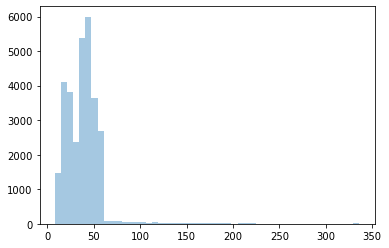

In [6]:
agg_patient_time = np.array(filter_train.groupby(['Patient_id'])['SepsisLabel']\
                            .count())

sns.distplot(agg_patient_time, kde=False);

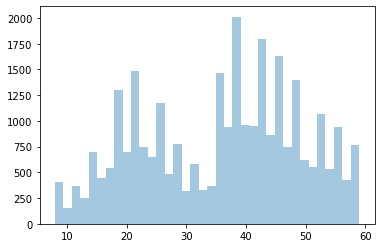

In [7]:
agg_patient_time = np.array(filter_train.groupby(['Patient_id'])['SepsisLabel']\
                            .count())

agg_patient_time = agg_patient_time[agg_patient_time < 60]

sns.distplot(agg_patient_time, kde=False);

In [8]:
temp = filter_train.groupby(['Patient_id'])['SepsisLabel'].count().reset_index()


sel_pid = np.array(temp[temp['SepsisLabel'] <=60]['Patient_id'])


patient_filter_train = filter_train[filter_train['Patient_id'].isin(sel_pid)]

In [9]:
len(patient_filter_train['Patient_id'].unique())

29434

In [10]:
grp_sepsis_rep = np.array(patient_filter_train.groupby(['Patient_id']) \
                          ['SepsisLabel'].sum())

len(grp_sepsis_rep[grp_sepsis_rep > 0])

1533

C:\Users\Administrator\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


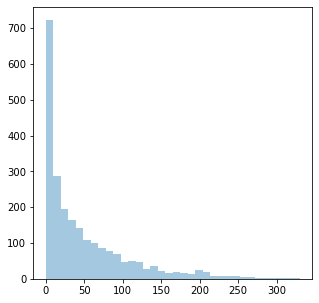

In [11]:
temp = filter_train.groupby(['Patient_id'])['SepsisLabel']\
       .sum().reset_index()

sepsis_train_pid = np.array(temp[temp['SepsisLabel'] > 0]['Patient_id'])


temp_filter = filter_train[filter_train['Patient_id']\
                                   .isin(sepsis_train_pid)]

sepsis_time = []
tot_time = []


for pid in sepsis_train_pid:
  df = temp_filter[temp_filter['Patient_id']==pid]
  sepsis_time.append(df[df['SepsisLabel']==1]['time'].iloc[0])
  tot_time.append(df[df['SepsisLabel']==1]['time'][::-1].iloc[0])

rcParams['figure.figsize'] = 5, 5

  
sns.distplot(sepsis_time, kde=False);

C:\Users\Administrator\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

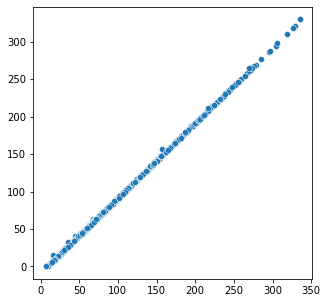

In [12]:
rcParams['figure.figsize'] = 5, 5


sns.scatterplot(tot_time, sepsis_time)

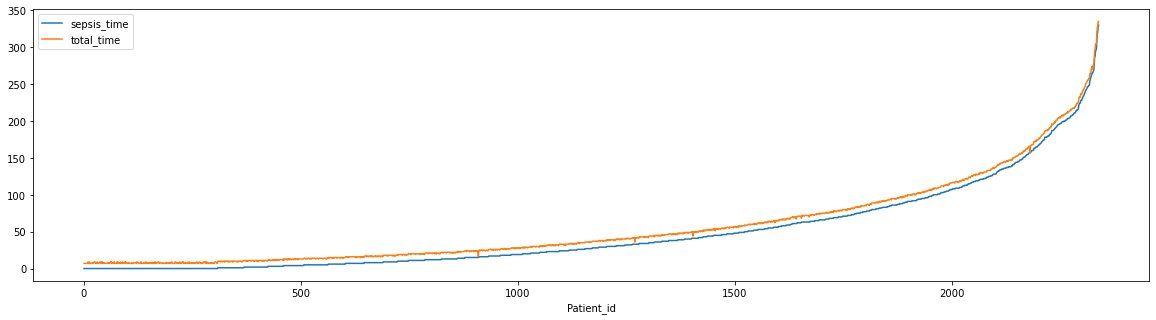

In [13]:
temp = pd.DataFrame()

temp['pid'] = sepsis_train_pid

temp['sepsis_time'] = sepsis_time

temp['tot_time'] = tot_time

temp.sort_values(by=['sepsis_time'], inplace=True)

temp['level'] = temp.reset_index().index

rcParams['figure.figsize'] = 20, 5


plt.plot(temp['level'], temp['sepsis_time'])
plt.plot(temp['level'], temp['tot_time'])
_ = plt.xlabel('Patient_id')
_ = plt.legend(['sepsis_time', 'total_time'])

In [14]:
pids = np.array(filter_train['Patient_id'].unique())

missing_dict = {}
pid_missing_dict = {}


for col in ['HR','MAP', 'Resp', 'Temp','WBC', 'PaCO2']:
  missing_dict[col] = []
  pid_missing_dict[col] = []
  for pid in pids:
    temp = filter_train[filter_train['Patient_id'] == pid]
    missing = (temp[col].isnull().sum() / temp.shape[0]) * 100
    missing_dict[col].append(missing)
    if missing > 99:
      pid_missing_dict[col].append(pid)

C:\Users\Administrator\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


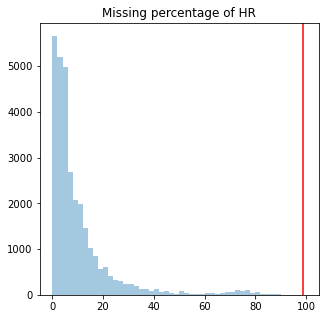

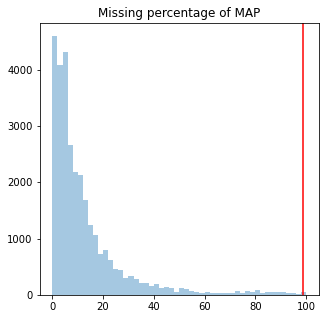

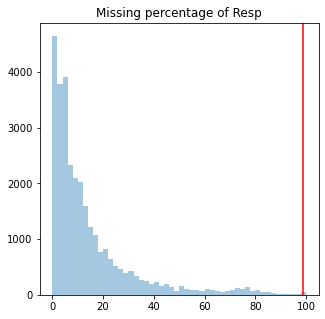

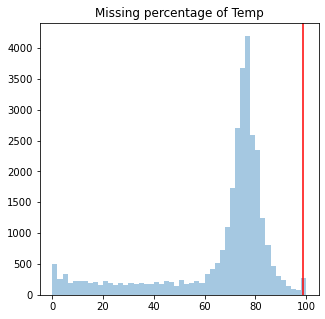

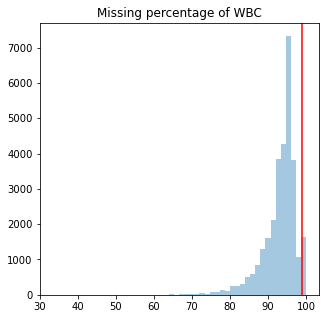

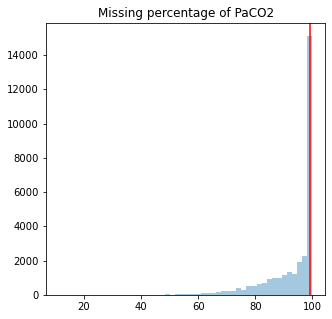

In [15]:
rcParams['figure.figsize'] = 5, 5


for i,col in enumerate(missing_dict.keys()):
  plt.figure(i)
  plt.axvline(99, 0,90, color='r')

  plt.title("Missing percentage of " + str(col))
  sns.distplot(missing_dict[col], kde=False);